## Libraries

In [2]:
import math
import sys
import os
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
path = Path(os.path.abspath(''))
util_path = str(path.parent.absolute())

if util_path not in sys.path:
    sys.path.append(util_path)
    
from utils import helpers

In [4]:
pd.set_option('display.max_columns',None)
plt.style.use("fivethirtyeight")
np.seterr(divide = 'ignore')
warnings.filterwarnings('ignore')

## Import Data

In [5]:
def get_marketing_data():
    data = pd.read_csv("../data/raw/bank-full.csv", sep=';')
    return data

## Understand Data Shape

In [6]:
df = get_marketing_data()
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [7]:
print('df shape: {}'.format(df.shape))

df shape: (45211, 17)


In [8]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [10]:
for column in df.columns:
    print('Column: {} - Unique Values: {}'.format(column, df[column].unique()))

Column: age - Unique Values: [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]
Column: job - Unique Values: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
Column: marital - Unique Values: ['married' 'single' 'divorced']
Column: education - Unique Values: ['tertiary' 'secondary' 'unknown' 'primary']
Column: default - Unique Values: ['no' 'yes']
Column: balance - Unique Values: [ 2143    29     2 ...  8205 14204 16353]
Column: housing - Unique Values: ['yes' 'no']
Column: loan - Unique Values: ['no' 'yes']
Column: contact - Unique Values: ['unknown' 'cellular' 'telephone']
Column: day - Unique Values: [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
Column: 

In [11]:
df.isna().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

## Pre-processing

In [12]:
# Pre-processing with method chaining

cols_to_category = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "poutcome",
]
df[cols_to_category] = df[cols_to_category].astype("category")
df["y"] = np.where(df["y"] == "no", 0, 1)

## EDA

In [81]:
from scipy import stats
# auto eval which outlier method better based on Shapiro Wilks?

stats.shapiro(np.log(df['balance']))

ShapiroResult(statistic=nan, pvalue=1.0)

1. Visualize all the cols (x)
2. Check target distribution (x)
3. Check for missing values (x)
4. Check for outliers (x)

In [196]:
from importlib import reload  # Python 3.4+
reload(helpers)

<module 'utils.helpers' from '/home/david.zhao/value-ml/utils/helpers.py'>

In [69]:
# configuring parameters
target_name = 'y'
outcome_str = 'uptake'

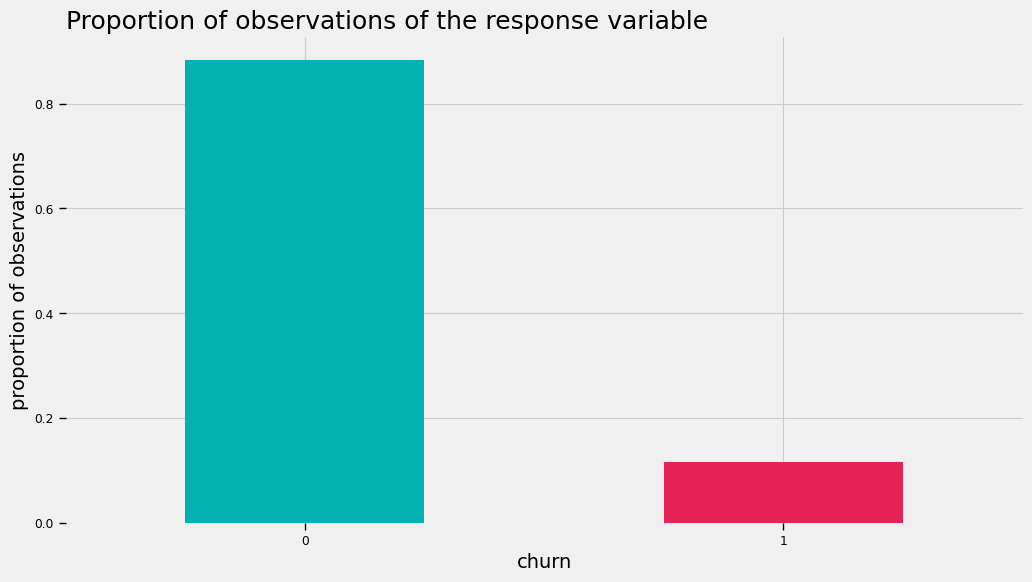

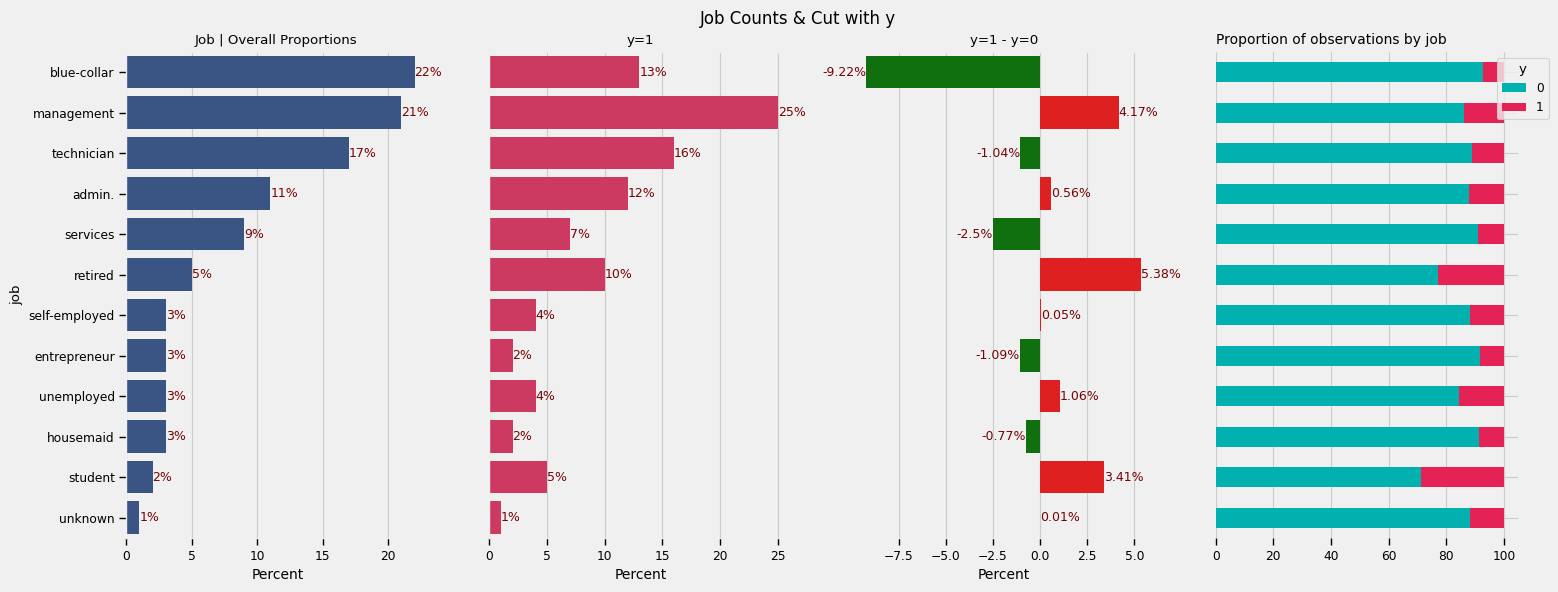

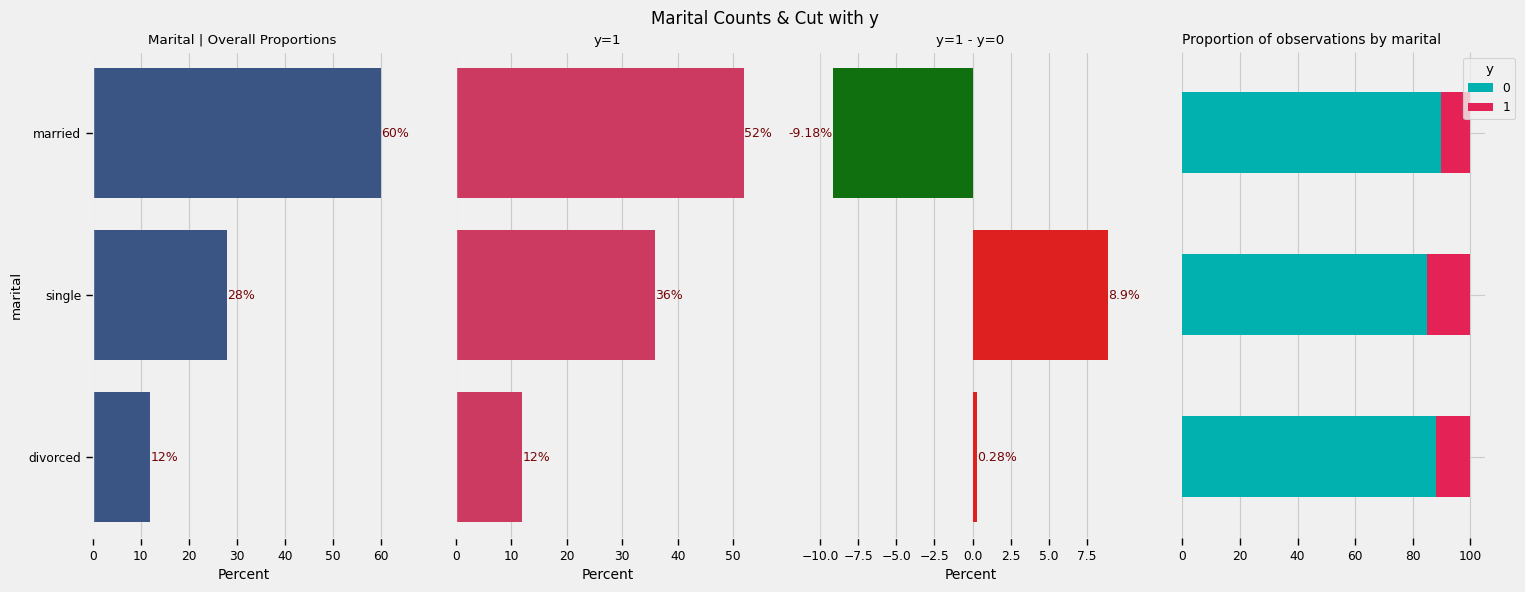

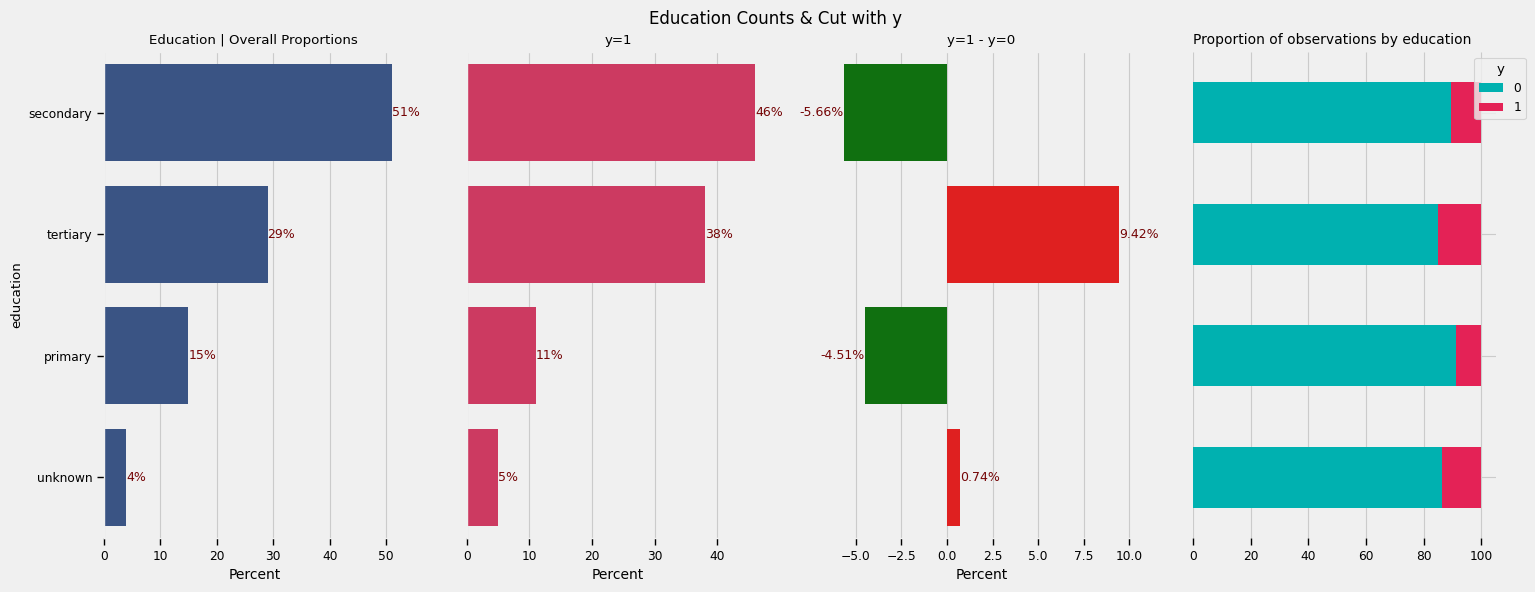

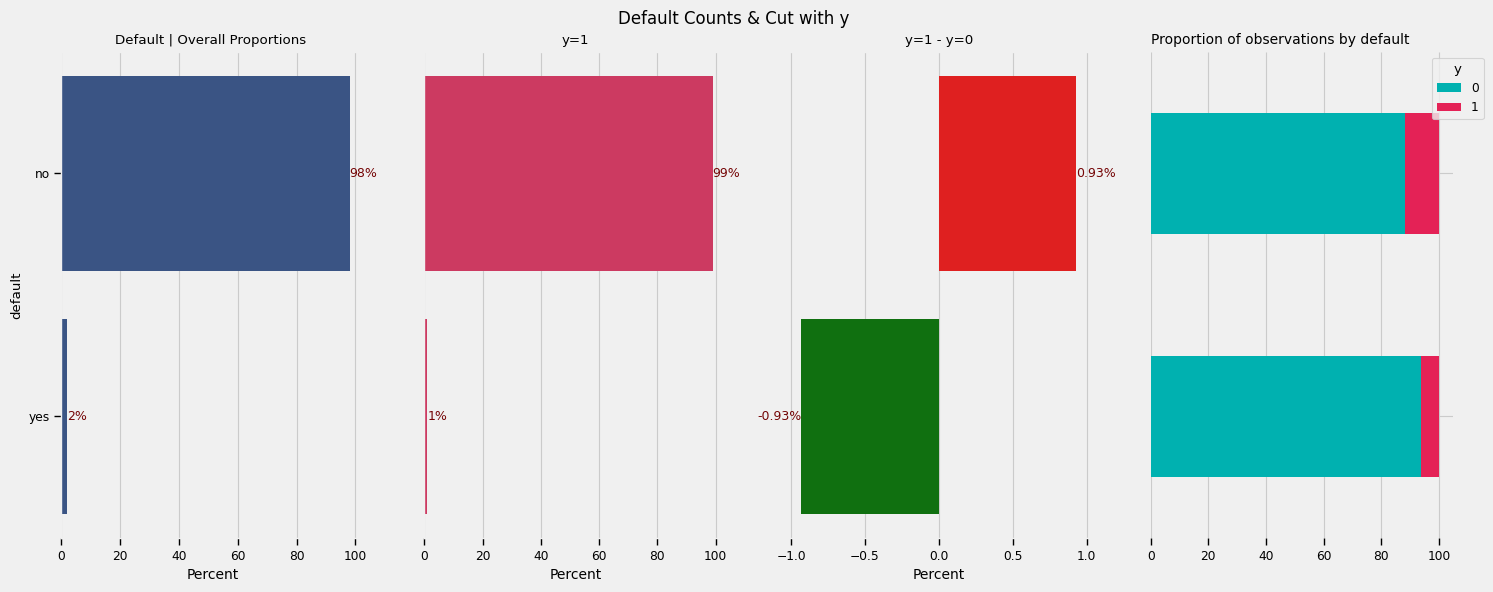

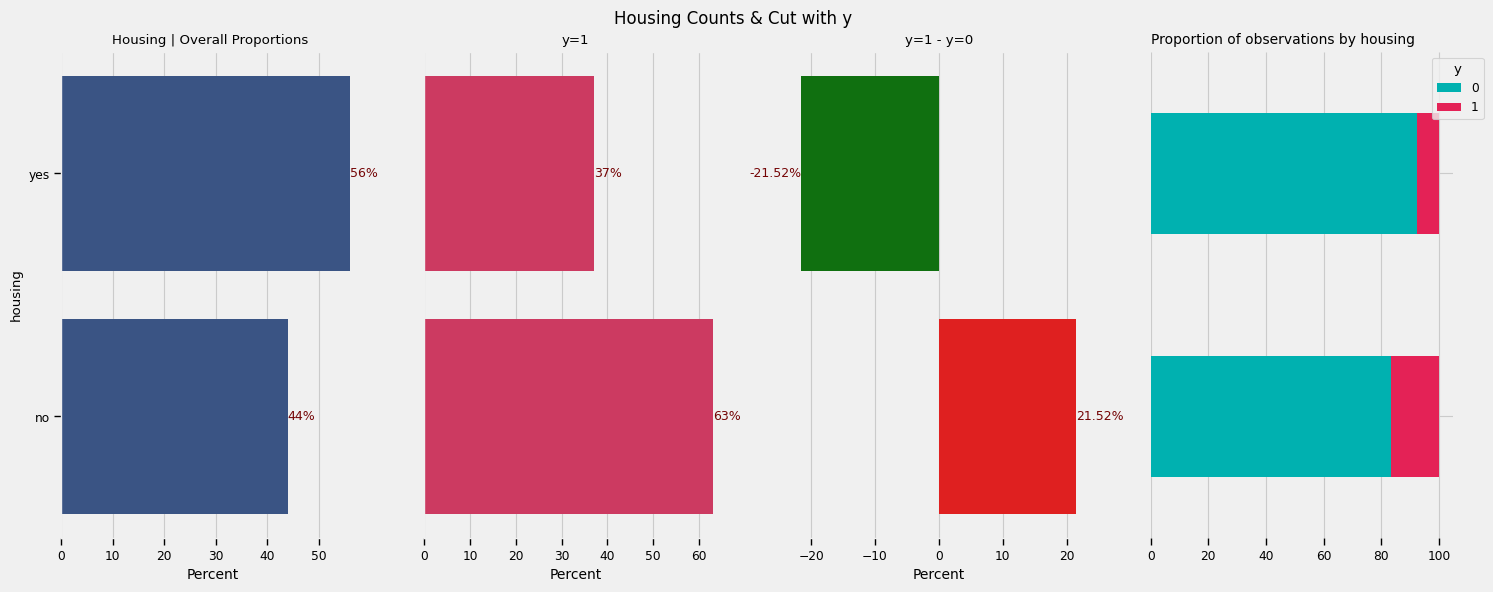

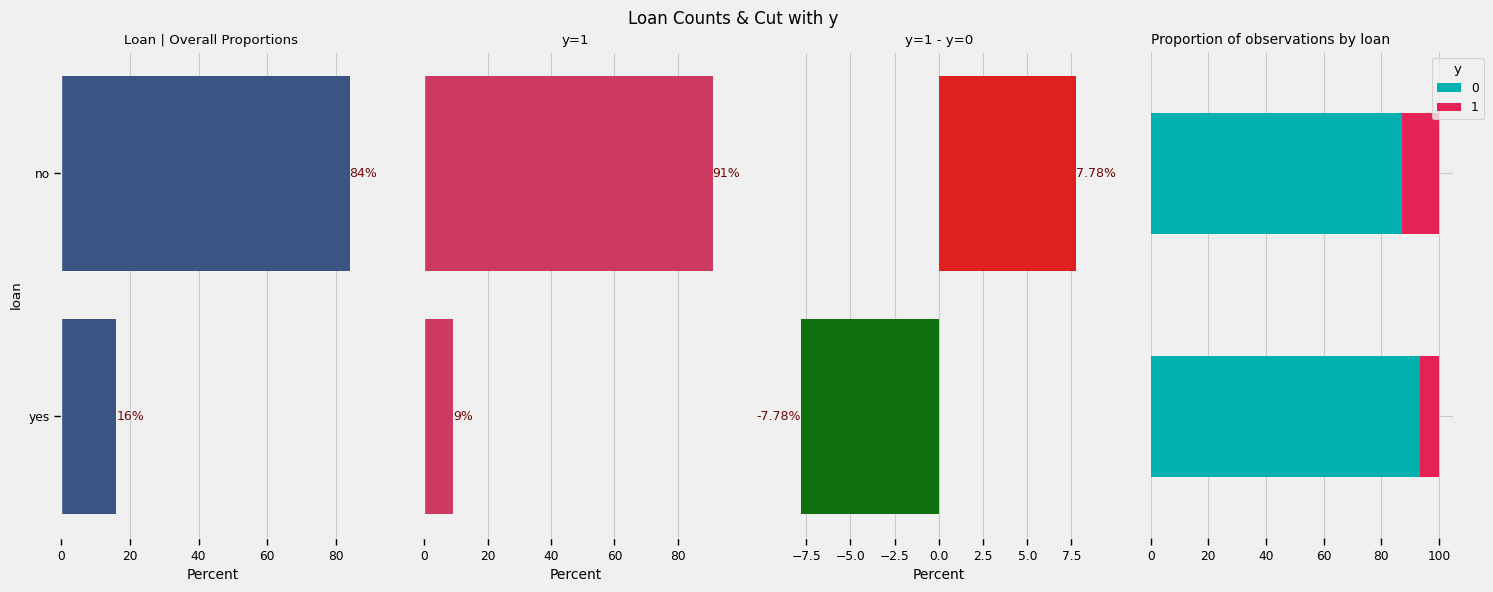

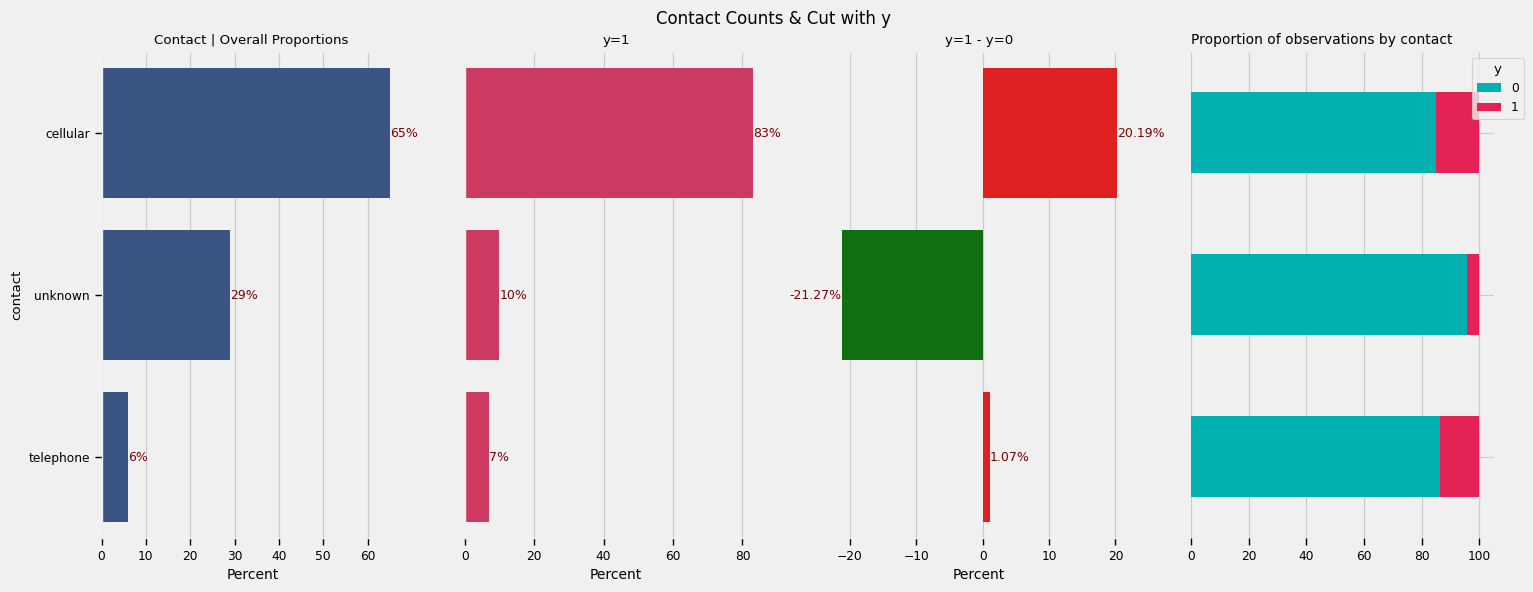

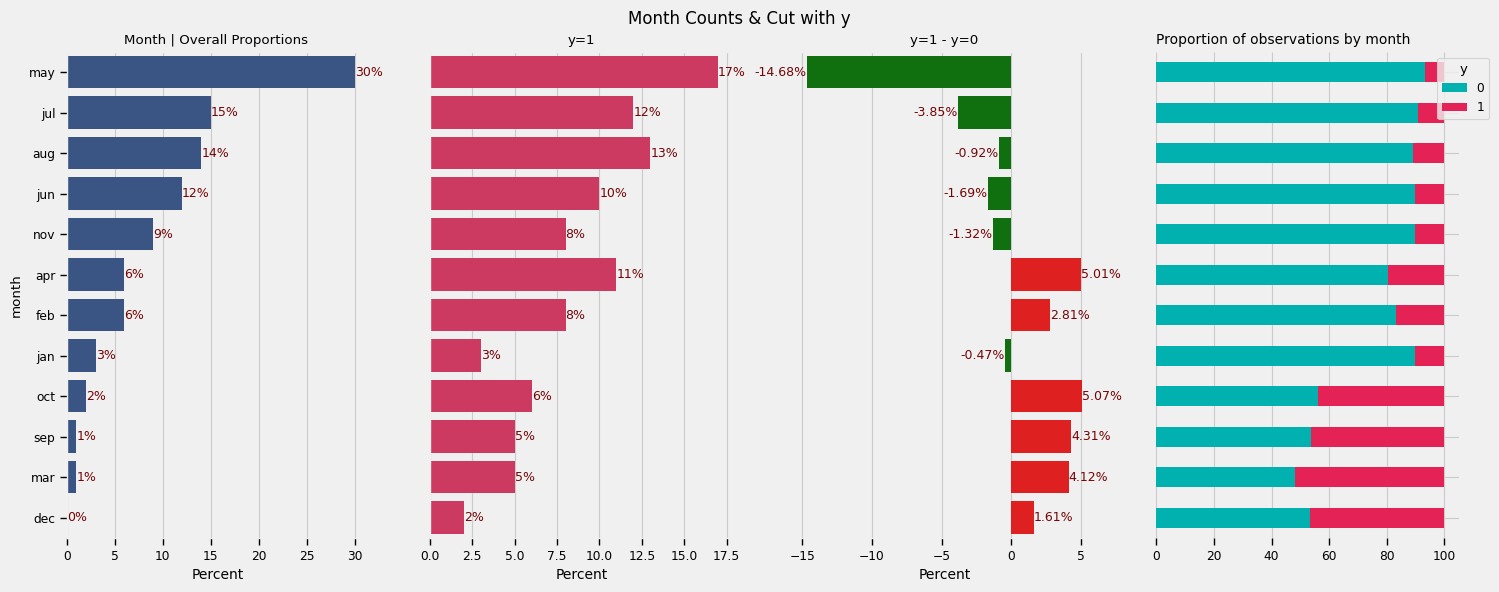

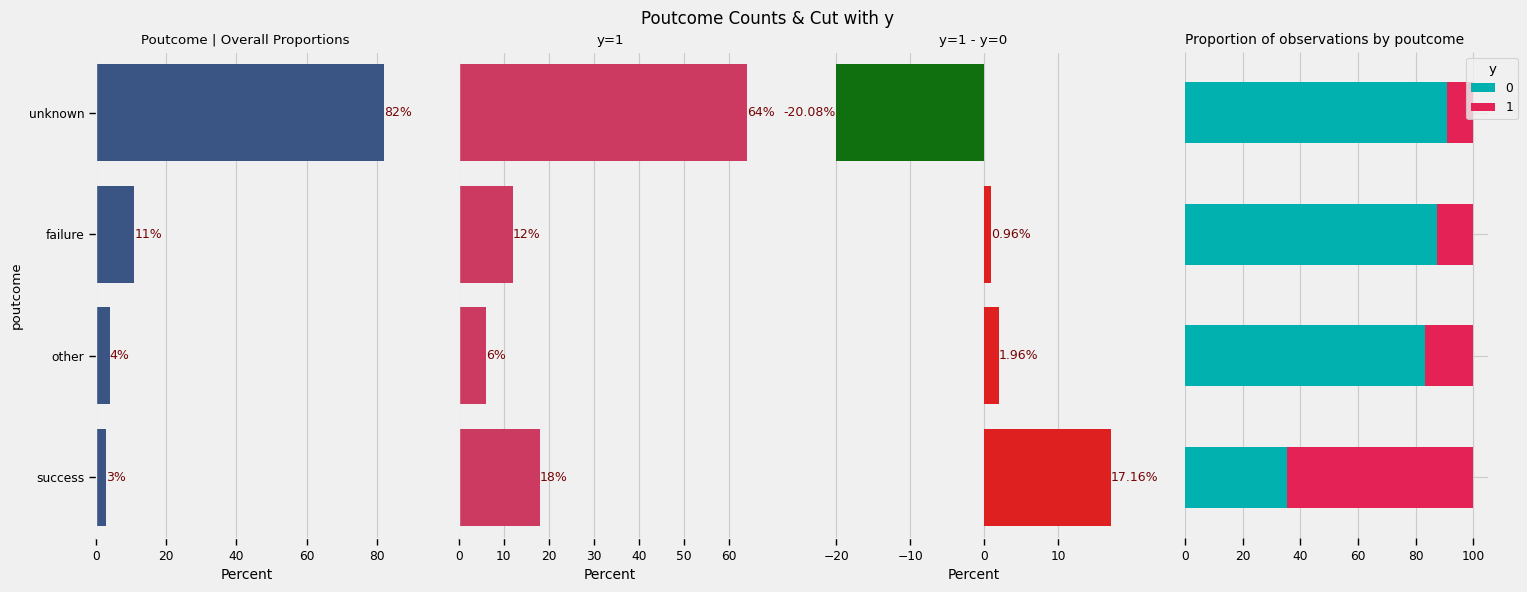

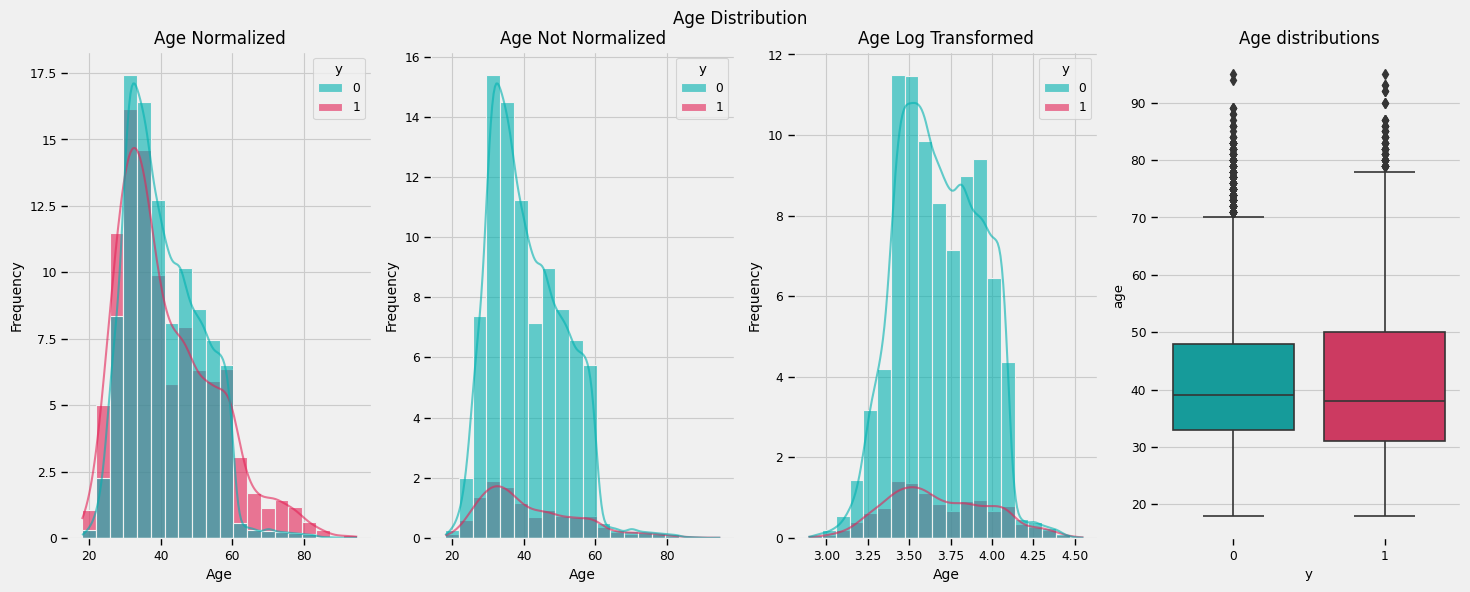

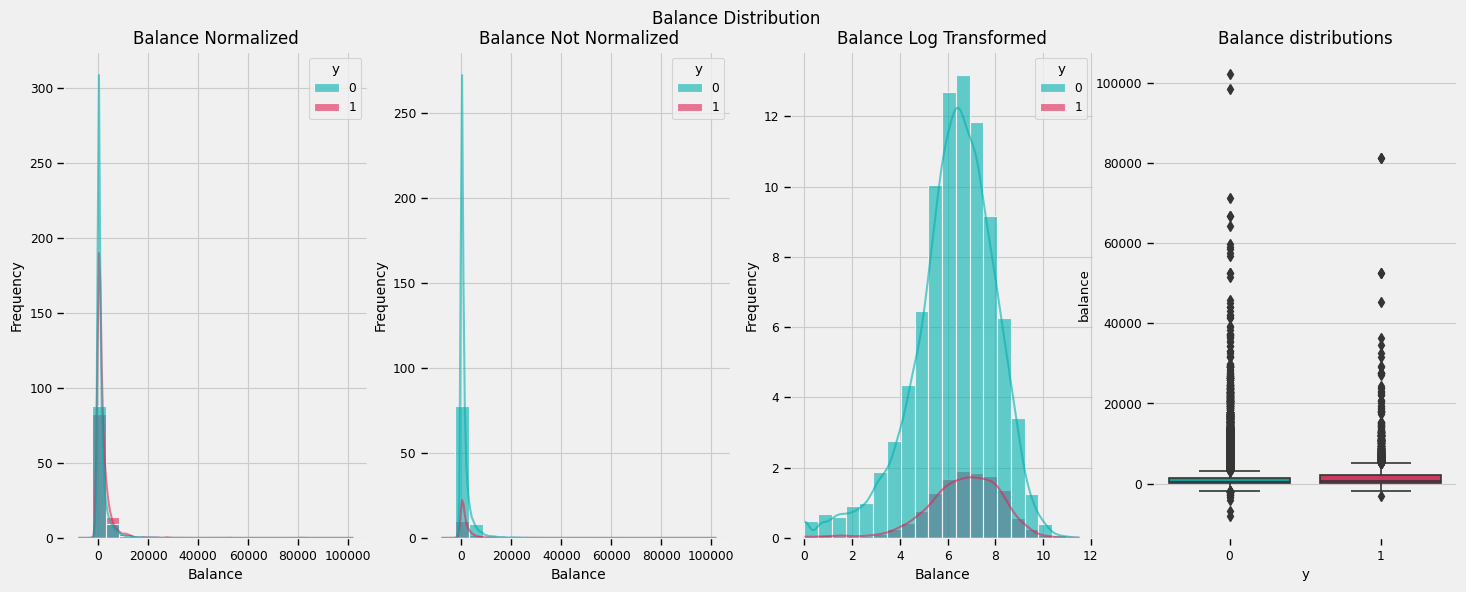

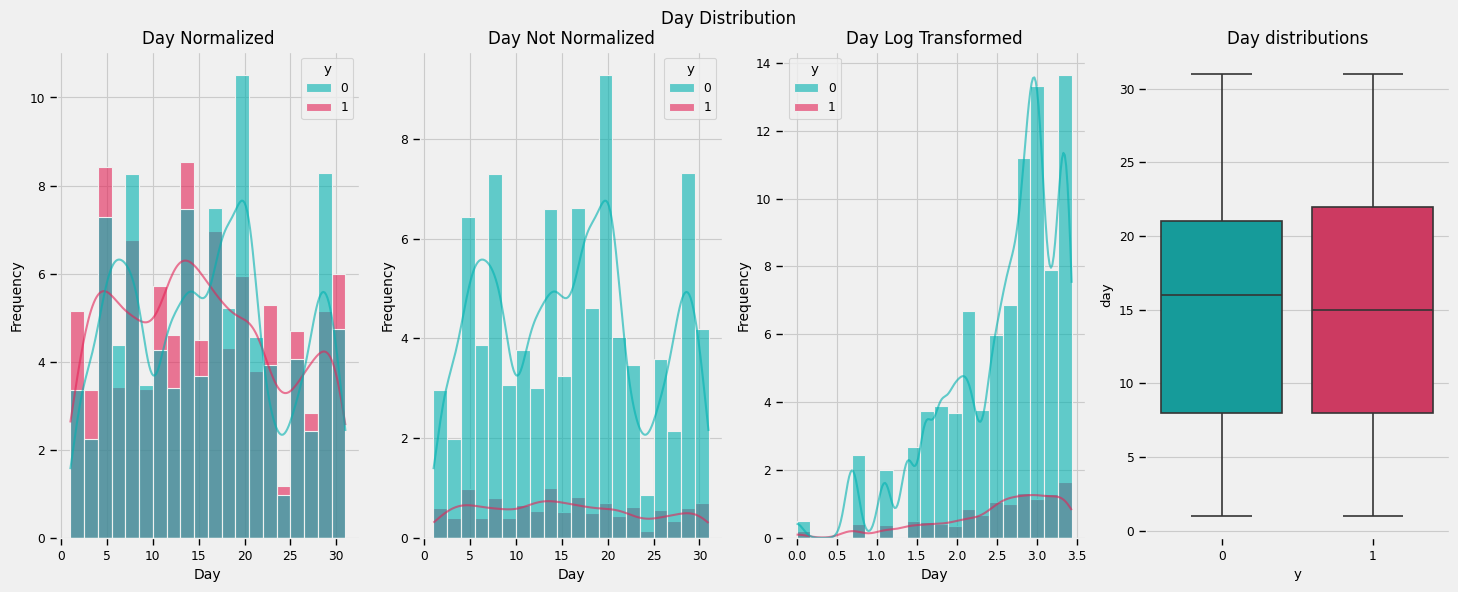

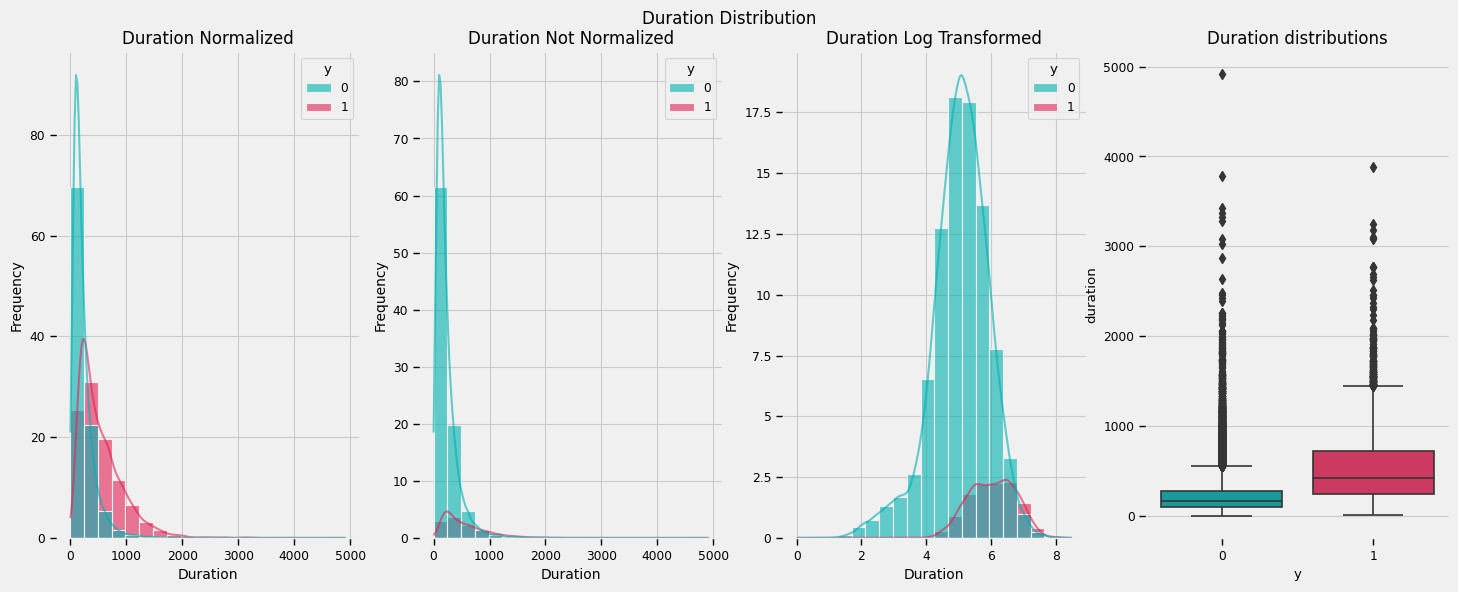

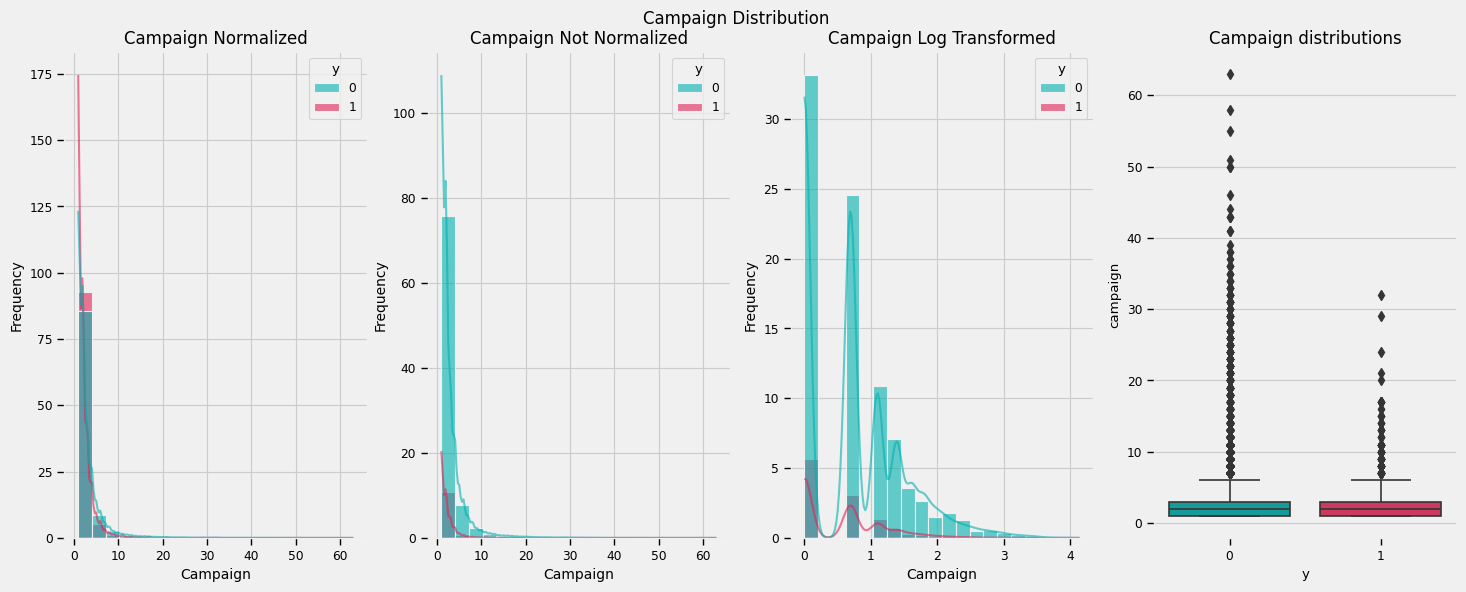

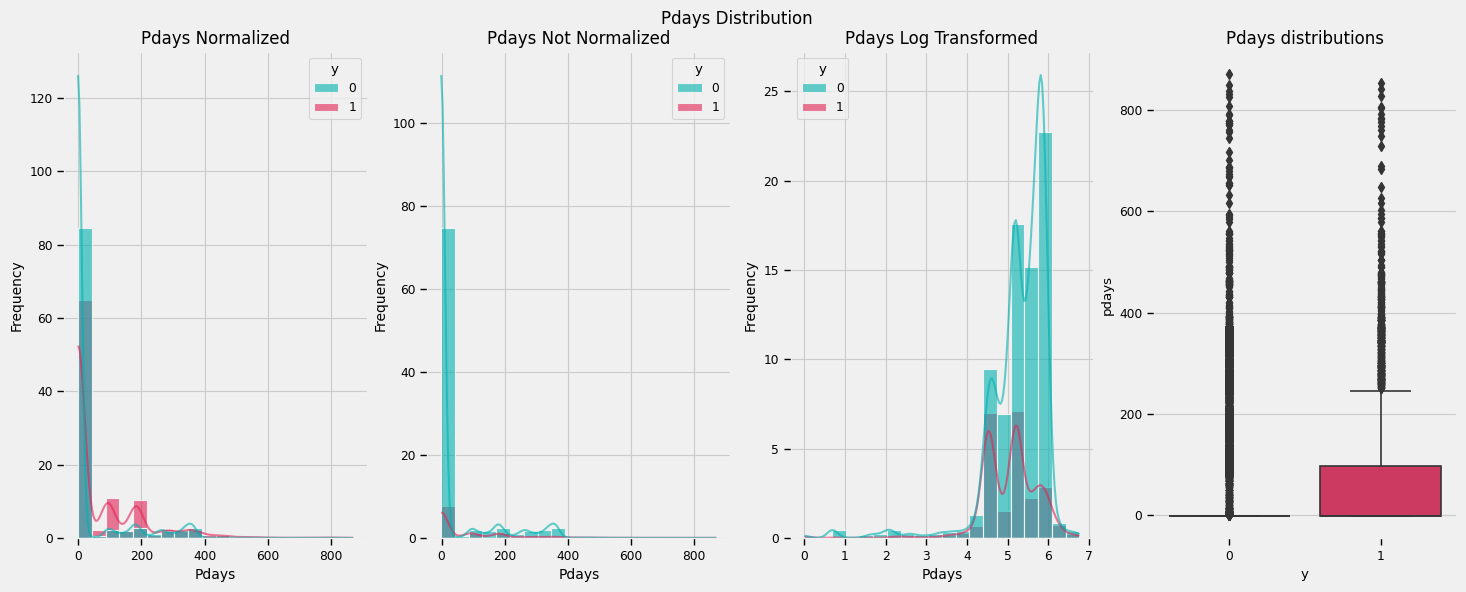

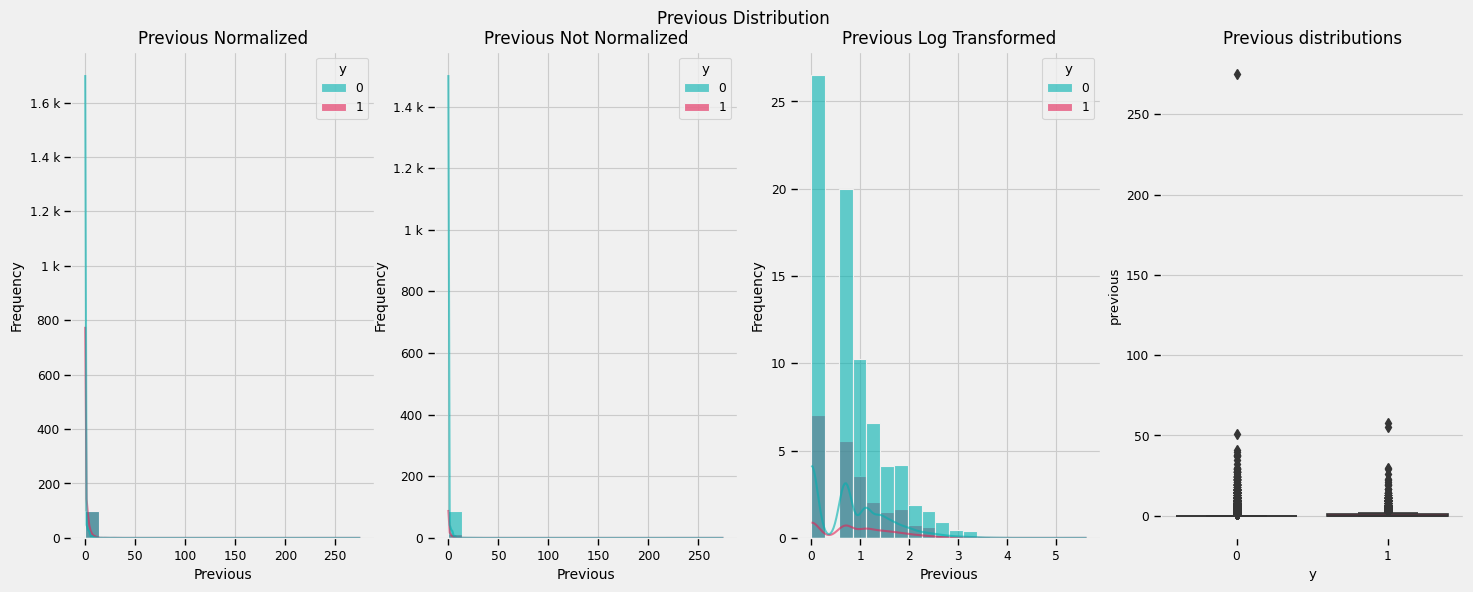

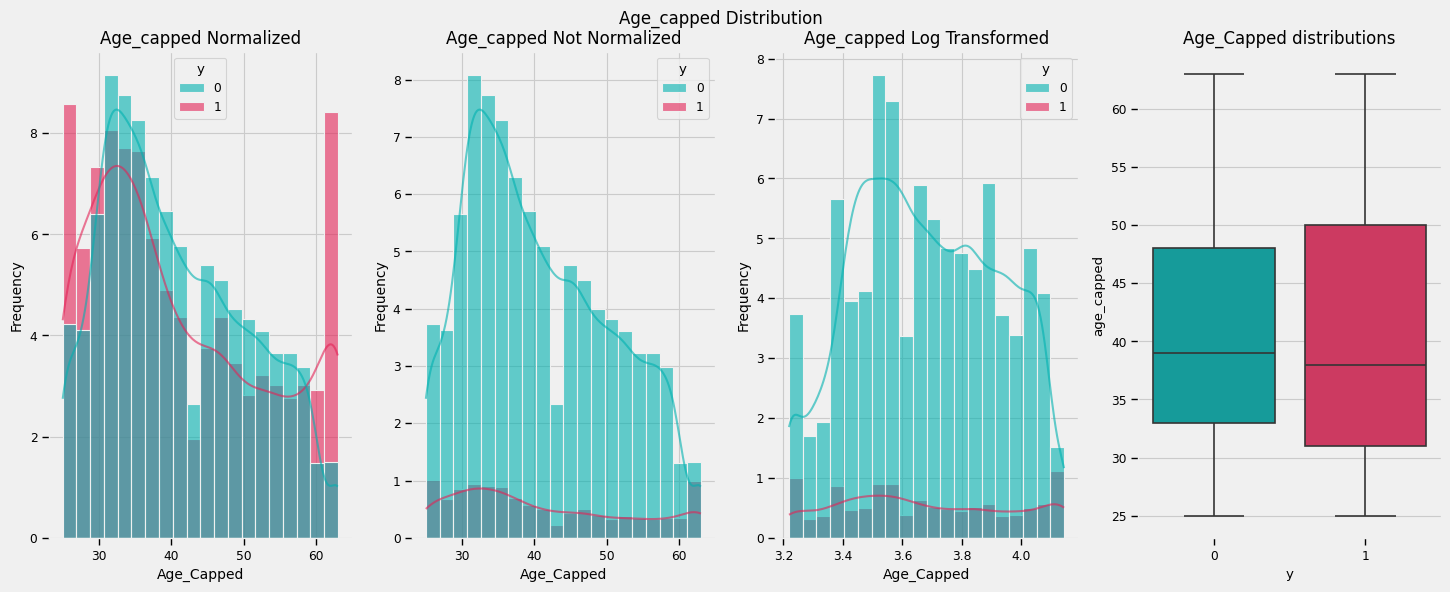

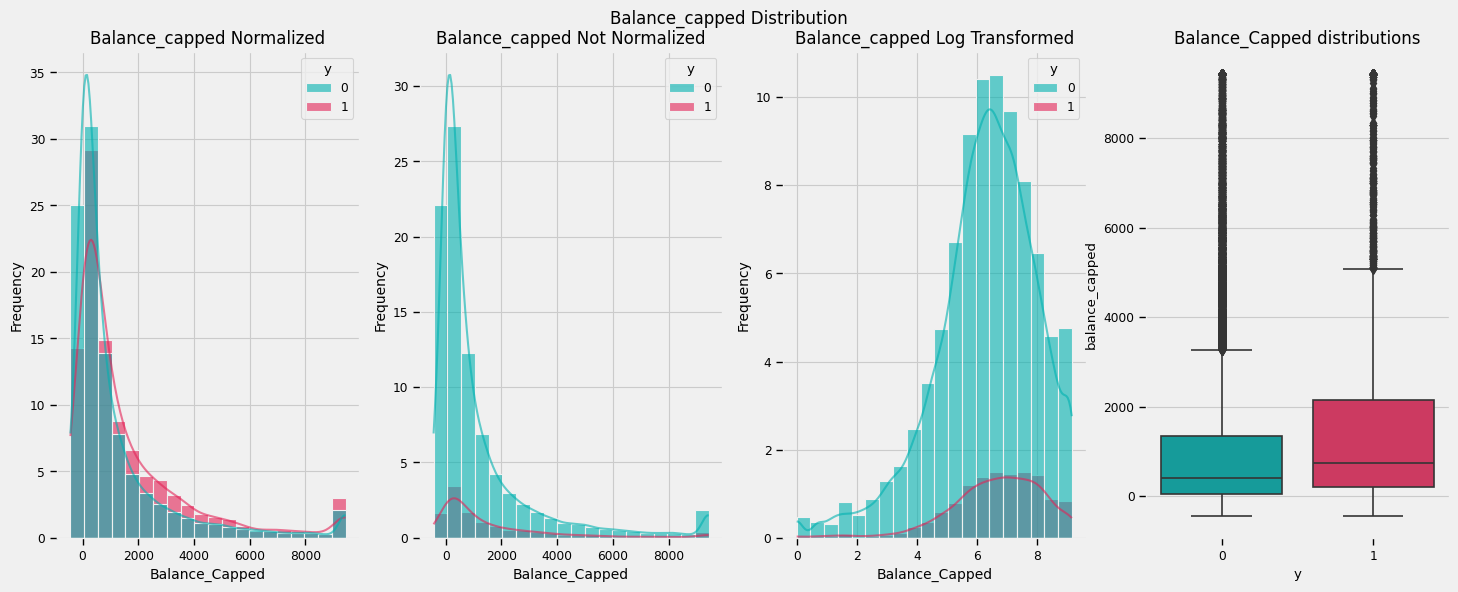

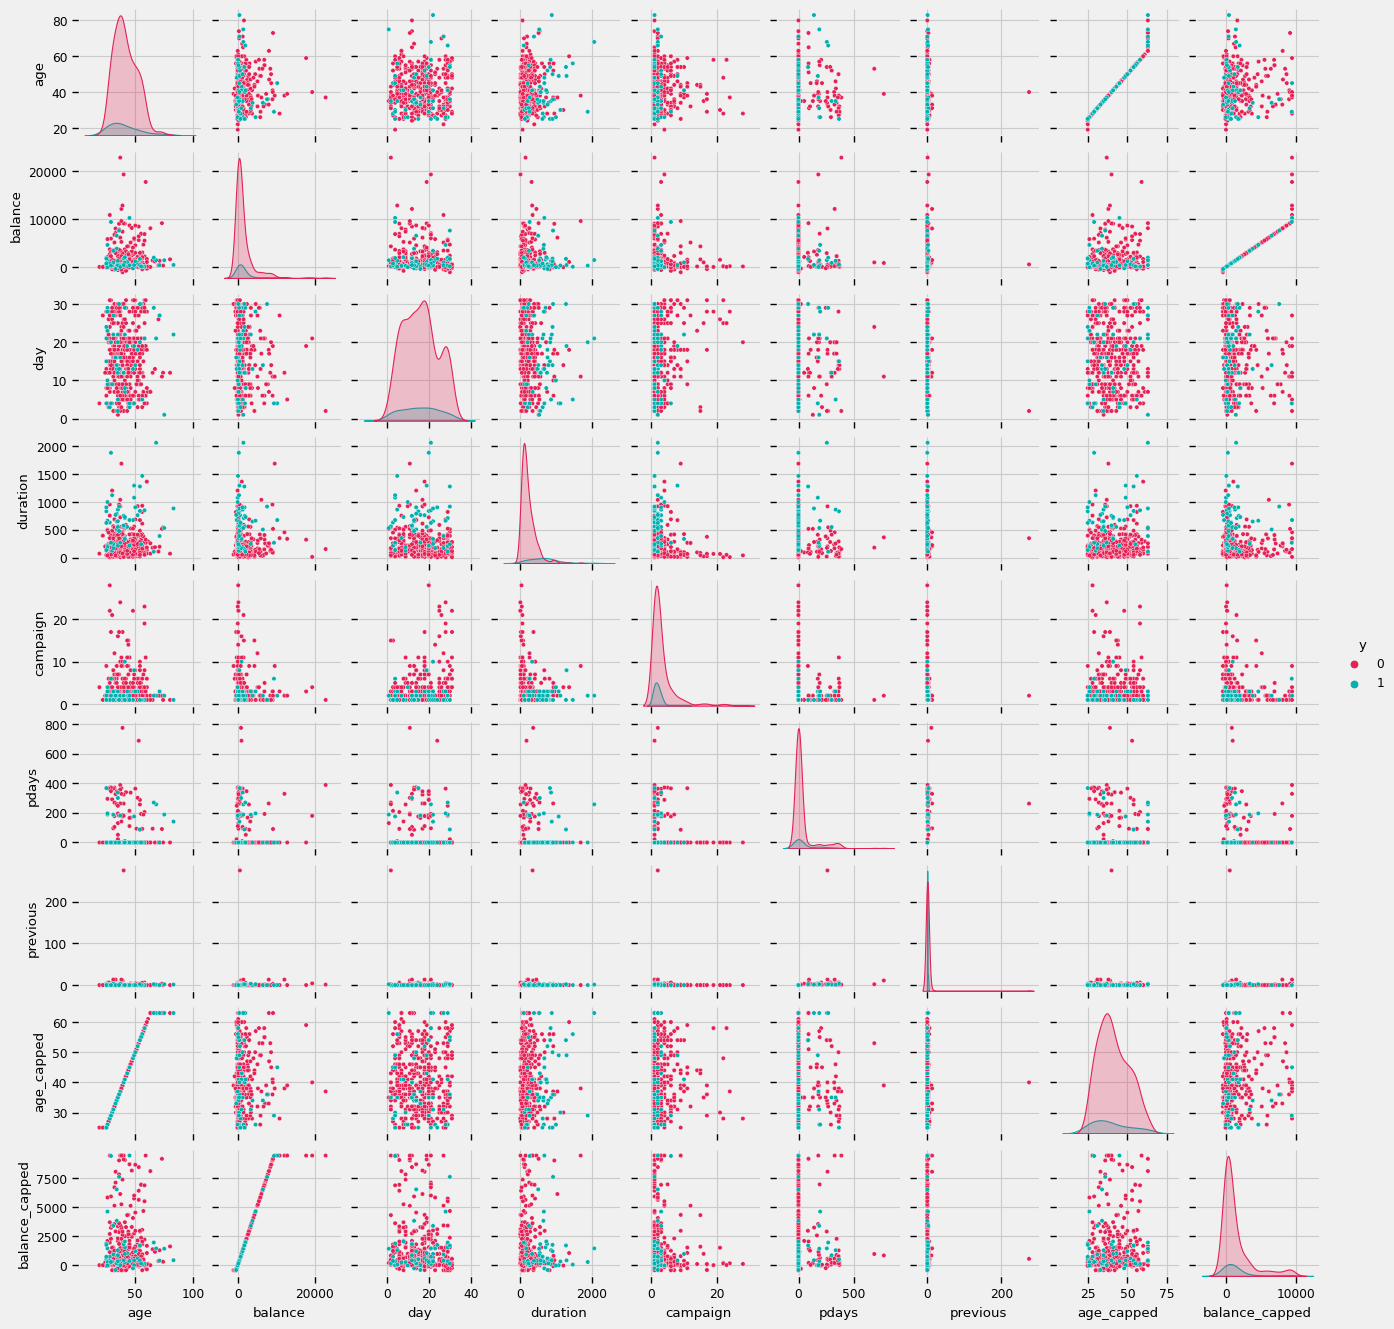

,age,balance,day,duration,campaign,pdays,previous,y,age_capped,balance_capped
age,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
balance,0.10,nan,nan,nan,nan,nan,nan,nan,nan,nan
day,-0.01,0.00,nan,nan,nan,nan,nan,nan,nan,nan
duration,-0.00,0.02,-0.03,nan,nan,nan,nan,nan,nan,nan
campaign,0.00,-0.01,0.16,-0.08,nan,nan,nan,nan,nan,nan
pdays,-0.02,0.00,-0.09,-0.00,-0.09,nan,nan,nan,nan,nan
previous,0.00,0.02,-0.05,0.00,-0.03,0.45,nan,nan,nan,nan
y,0.03,0.05,-0.03,0.39,-0.07,0.10,0.09,nan,nan,nan
age_capped,0.99,0.09,-0.01,-0.01,0.01,-0.03,-0.00,0.01,nan,nan
balance_capped,0.11,0.85,0.01,0.03,-0.02,0.01,0.03,0.07,0.11,nan


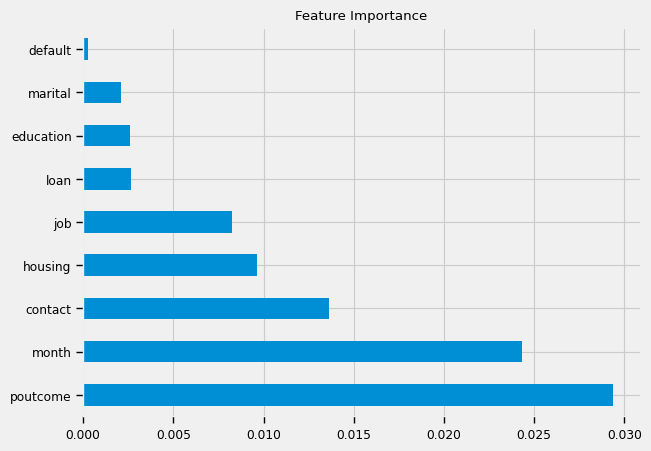

In [138]:
# 1. visualize features
eda_helper = helpers.EDAHelper(df, target_name)
eda_helper.init_diagnostic()

In [197]:
# 2. treat outliers
strategy = {
    'iso': True,
    'cols': [
        ['age', 'cap', {'kind': 'percentile', 'threshold':(10, 90)}],
        ['balance', 'filter', {'kind': 'iqr'}]
    ]
}

outlier_helper = helpers.OutlierHelper(df, strategy)

df_filtered = outlier_helper.treat_outliers()

4521 outliers identified by isolation forest
3692 outliers identified in col=balance based on {'kind': 'iqr'}
8213 outliers in total identified


## Pre-processing

1. One-hot encode features
2. Scale numerical features
3. Feature selection/ importance /Drop useless/ highly correlated features
4. Impute any missing data
5. Train/ test split

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mutual_info_score, r2_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# 3. Pipeline pre-processing

In [ ]:
# 4. Automatically look at feature importance

In [ ]:
# 5. Model eval

In [ ]:
# 6. Configure final model/ save down / log

In [ ]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder

# from sklearn.compose import ColumnTransformer

# from sklearn.metrics import mutual_info_score, r2_score, confusion_matrix, classification_report

# from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# from sklearn.pipeline import Pipeline

# from sklearn.linear_model import LogisticRegression

# from sklearn.ensemble import GradientBoostingClassifier

# df_telco_transformed = df_telco.copy()

# ​

# # label encoding (binary variables)

# label_encoding_columns = ['Gender', 'Partner', 'Dependents', 'PaperlessBilling', 'PhoneService']

# ​

# ​

# # one-hot encoding (categorical variables with more than two levels)

# one_hot_encoding_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 

#                             'TechSupport', 'StreamingTV',  'StreamingMovies', 'Contract', 'PaymentMethod']

# ​

# # min-max normalization (numeric variables)

# min_max_columns = ['Tenure', 'MonthlyCharges', 'TotalCharges']

# X = df_telco_transformed.drop('Churn',axis=1)

# y = 1 * (df_telco_transformed['Churn']== 'Yes')

# ​

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# model = GradientBoostingClassifier()

# pipe = Pipeline(steps = 

#     [('preprocessor', ColumnTransformer(

#         transformers=

#         [('numeric', 

#           Pipeline(steps=[

#               ('imputer', 'passthrough'), 

#               ('scaler', MinMaxScaler())]),

#           min_max_columns),

         

#          ('categorical', 

#           Pipeline(steps=[

#               ('imputer', 'passthrough'), 

#               ('encoder', OneHotEncoder())]), 

#           one_hot_encoding_columns),

         

#          ('binary', Pipeline(steps=[

#              ('imputer', 'passthrough'),

#              ('bin_encoder', OrdinalEncoder())]),

#           label_encoding_columns)])),

#     ('classify', model)

#     ])

# log_model = pipe.fit(X_train, y_train)

# print(log_model)

# Model Selection

# # define the parameter grid

# param_grid = {'classify__n_estimators': [80, 90, 100, 110, 115, 120],

#                    'classify__max_depth': [3, 4, 5, 6],

#                    'classify__max_features': [None, 'auto', 'sqrt', 'log2'], 

#                    'classify__min_samples_split': [2, 3, 4, 5]}

# ​

# ​

# # define the RandomizedSearchCV class for trying different parameter combinations

# random_search = RandomizedSearchCV(estimator=pipe,

#                                    param_distributions=param_grid,

#                                    cv=5,

#                                    n_iter=150,

#                                    n_jobs=-1)

# #grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)

# ​

# # fitting the model for random search 

# random_search.fit(X_train, y_train)

# ​

# # print best parameter after tuning

# print(random_search.best_params_)

# # make the predictions

# random_search_predictions = random_search.predict(X_test)

# ​

# # construct the confusion matrix

# confusion_matrix = confusion_matrix(y_test, random_search_predictions)

# ​

# # visualize the confusion matrix

# confusion_matrix

